# Run GCI with pytket

In [1]:
from qibo.backends import construct_backend
from qibo import hamiltonians, set_backend
from pytket import Circuit, OpType
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pytket.qasm
from copy import deepcopy

## Import initializing circuit

In [2]:
# XXZ model matrix
from qibo.symbols import X, Y, Z
def construct_XXZ(nqubits, delta=0.5, boundary='closed'):
    if boundary == 'periodic' or boundary == 'closed':
        return hamiltonians.XXZ(nqubits, delta).matrix
    elif boundary == 'open':
        H_sym = sum([X(i)*X(i+1)+ Y(i)*Y(i+1) + delta* Z(i)*Z(i+1) for i in range(nqubits-1)])
        return hamiltonians.SymbolicHamiltonian(H_sym).matrix

In [4]:
# import initialization
L = 10
delta = 1
nlayers = 2
H_matrix = construct_XXZ(L, delta, "open")
psi0 = np.zeros(2**L)
psi0[0] = 1
file_path = f"results/circuit_qasm/cobyla_{L}q_{nlayers}l_XXZ/hva_circ.qasm"
circ_init = pytket.qasm.circuit_from_qasm(file_path)
U_init = circ_init.get_unitary()
psi_init = U_init @ psi0
print(np.vdot(psi_init, H_matrix @ psi_init).real)

[Qibo 0.2.20|WARNING|2025-07-24 16:29:05]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


-16.710157214197903


## Define magnetic field

In [5]:
# magnetic field
def magnetic_field_circ(coefs, t):
    # implments e^{-itD}
    nqubits = len(coefs)
    qc = Circuit(nqubits)
    
    for idx, coef in enumerate(coefs):
        theta = 2 * t * coef / np.pi
        qc.Rz(theta, idx)
    return qc    

# loss function

def gci_analytical_loss(H, U, D_coefs, s):
    """Return the analytical loss from a GCI step

    Args:
        H (np.array): the Input Hamiltonian matrix
        U (np.array): the VQE circuit unitary
        D_coefs (list): the coefficients of the magnetic field circuit
        s (float): the GCI rotation duration
    """
    U_dag = U.T.conjugate()
    d = magnetic_field_circ(D_coefs, s).get_unitary()
    d_dag = d.conjugate()
    h = sp.linalg.expm(-1j*s*H)
    psi0 = np.zeros(2**len(D_coefs))
    psi0[0] = 1
    U1 = U @ d_dag @ U_dag @ h @ U @ d
    return np.vdot(U1 @ psi0, H @ U1 @ psi0).real

In [6]:
# test
coefs = [0]*L
print(np.abs(gci_analytical_loss(H_matrix, U_init, coefs, 0)-np.vdot(psi_init, H_matrix @ psi_init).real)<1e-3)

True


### Optimize step with fixed magnetic field

In [7]:
from scipy.optimize import minimize_scalar

In [8]:
coefs_init = [np.sin(i/20*np.pi/2)for i in range(L)]
objective = lambda s: gci_analytical_loss(H_matrix, U_init, coefs_init, np.abs(s))

In [9]:
res = minimize_scalar(
    objective,                  
    method='brent',    
    options={'maxiter': 15,
             'xtol': 1e-3} 
)
print(res.fun)
print(res.x)

-16.827776874006474
0.20219978633093347


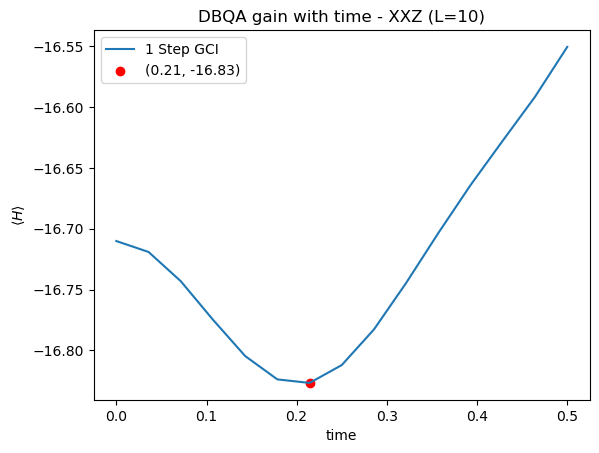

In [10]:
# sweep
s_space = np.linspace(0, 0.5, 15)
loss_init_ls = []
for s in s_space:
    loss_init_ls.append(gci_analytical_loss(H_matrix, U_init, coefs_init, s))

min_loss_init = min(loss_init_ls)
min_idx = loss_init_ls.index(min_loss_init)
s_min_init = s_space[min_idx]

plt.plot(s_space, loss_init_ls, label='1 Step GCI')
plt.scatter(s_min_init, min_loss_init, color='red', label=f"({s_min_init:.2f}, {min_loss_init:.2f})")
plt.title(f'DBQA gain with time - XXZ (L={L})')
plt.xlabel('time')
plt.ylabel(r'$\langle H\rangle$')
plt.legend()

### Optimize magnetic field and step

In [11]:
# coefs_init = [np.sin(i/20*np.pi/2)for i in range(L)]
D_s = np.append(coefs_init, s_min_init)
objective = lambda D_s: gci_analytical_loss(H_matrix, U_init, D_s[:-1], np.abs(D_s[-1]))
print("Initial loss:", objective(D_s))

Initial loss: -16.8267567321248


In [12]:
max_iter = 1000
result = sp.optimize.minimize(
    objective,
    D_s,
    method="COBYLA",
    options={"disp": True, "maxiter": max_iter},
    tol=1e-2,
)

print(result.fun)
print(result.x)

Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 128   Least value of F = -16.867803004562738
The corresponding X is:
[1.03605243 1.03250116 0.24819423 0.31078775 0.34803165 0.43177045
 0.4669805  0.5863968  0.66412652 0.66318669 0.18298796]

-16.867803004562738
[1.03605243 1.03250116 0.24819423 0.31078775 0.34803165 0.43177045
 0.4669805  0.5863968  0.66412652 0.66318669 0.18298796]


## Build GCI circuit

In [13]:
# XXZ model circuit (native gates)
def XX_interaction(qc, q0, q1, t):
    qc.H(q0), qc.H(q1)
    qc.ZZPhase(t*2/np.pi, q0, q1)
    qc.H(q0), qc.H(q1)

def YY_interaction(qc, q0, q1, t):
    qc.Sdg(q0), qc.Sdg(q1)
    XX_interaction(qc, q0, q1, t)
    qc.S(q0), qc.S(q1)

def ZZ_interaction(qc, q0, q1, t):
    qc.ZZPhase(t*2/np.pi, q0, q1)
    
def XXZ_decomposition(nqubits, t, delta=0.5, qc=None, layer=2, boundary='closed'):
    # This function generates the circuit that simulates e^{itH}
    # where H is the XXZ model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        if boundary == 'periodic' or boundary == 'closed':
            # print('periodic case')
            if nqubits % 2 == 0:
                # even number of qubits add to odd pairs
                odd_starting_pairs.append([0, nqubits-1])
            else:
                even_starting_pairs.append([0, nqubits-1])
                # note that odd number of qubits result in degenerate ground states
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    if layer == 2:
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta)
        for q0, q1 in odd_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta) 
    elif layer == 3:
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t/2)
            YY_interaction(qc, q0, q1, t/2)
            ZZ_interaction(qc, q0, q1, t*delta/2)
        for q0, q1 in odd_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta) 
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t/2)
            YY_interaction(qc, q0, q1, t/2)
            ZZ_interaction(qc, q0, q1, t*delta/2)
    else:
        raise ValueError("Number of layers not supported, use either '2' or '3'.")
    return qc

In [18]:
D_coef = result.x[:-1]
t = result.x[-1]
sequence = [i for i in range(L)]
D_circ = magnetic_field_circ(D_coef, t)
D_circ_inverse = D_circ.dagger()
qc = deepcopy(D_circ)
qc.add_circuit(circ_init, sequence)
qc.add_circuit(XXZ_decomposition(L, t, layer=3, boundary='open'), sequence)
qc.add_circuit(circ_init.dagger(), sequence)
qc.add_circuit(D_circ_inverse, sequence)
qc.add_circuit(circ_init, sequence)

[Rz(0.120694) q[0]; Rz(0.12028) q[1]; Rz(0.0289131) q[2]; Rz(0.0362048) q[3]; Rz(0.0405435) q[4]; Rz(0.0502986) q[5]; Rz(0.0544003) q[6]; Rz(0.0683116) q[7]; Rz(0.0773666) q[8]; Rz(0.0772571) q[9]; X q[0]; X q[1]; X q[2]; X q[3]; X q[4]; X q[5]; X q[6]; X q[7]; X q[8]; X q[9]; H q[0]; H q[2]; H q[4]; H q[6]; H q[8]; CX q[0], q[1]; CX q[2], q[3]; CX q[4], q[5]; CX q[6], q[7]; CX q[8], q[9]; H q[0]; H q[1]; H q[2]; H q[3]; H q[4]; H q[5]; H q[6]; H q[7]; H q[8]; H q[9]; ZZPhase(0.406683) q[0], q[1]; ZZPhase(0.406683) q[2], q[3]; ZZPhase(0.406683) q[4], q[5]; ZZPhase(0.406683) q[6], q[7]; ZZPhase(0.406683) q[8], q[9]; H q[0]; H q[1]; H q[2]; H q[3]; H q[4]; H q[5]; H q[6]; H q[7]; H q[8]; H q[9]; Sdg q[0]; Sdg q[1]; Sdg q[2]; Sdg q[3]; Sdg q[4]; Sdg q[5]; Sdg q[6]; Sdg q[7]; Sdg q[8]; Sdg q[9]; H q[0]; H q[1]; H q[2]; H q[3]; H q[4]; H q[5]; H q[6]; H q[7]; H q[8]; H q[9]; ZZPhase(0.406683) q[0], q[1]; ZZPhase(0.406683) q[2], q[3]; ZZPhase(0.406683) q[4], q[5]; ZZPhase(0.406683) q[6], q[7

In [19]:
vals, vecs = np.linalg.eigh(H_matrix)
target_energy = vals[0]
vqe_energy = np.vdot(psi_init, H_matrix @ psi_init).real
dbqa_energy = gci_analytical_loss(H_matrix, U_init, D_coef, t)
dbqa_circ_U = qc.get_unitary()
dbqa_circuit_energy = np.vdot(dbqa_circ_U@psi0, H_matrix@dbqa_circ_U@psi0).real
print('Target enegry:', target_energy)
print('Initial energy:', np.vdot(psi0, H_matrix @ psi0).real)
print('VQE energy:', vqe_energy)
print('DBQA energy (analytical):', dbqa_energy)
print('DBQA energy (circuit):', dbqa_circuit_energy)

Target enegry: -17.032140829131528
Initial energy: 9.0
VQE energy: -16.710157214197903
DBQA energy (analytical): -16.867803004562738
DBQA energy (circuit): -16.589651101919884


In [20]:
print("Circuit depth:", qc.depth())
print("Circuit total gate count:", qc.n_gates)
num_cnots = sum(1 for command in qc if command.op.type == OpType.CX)
print("Circuit CNOT count:", num_cnots)

Circuit depth: 146
Circuit total gate count: 1100
Circuit CNOT count: 15
